<a href="https://colab.research.google.com/github/Fieldwater/BookRecommenderSystem/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Residual Network

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class ResNet2(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet2, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    # return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet2(BasicBlock, [4, 6, 4, 3])

In [2]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
  # torch.numel() returns number of elements in a tensor
  
m = project1_model()
print(count_parameters(m))

4902186


## Main function

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
net = project1_model()
print(count_parameters(net))
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train_loss_history = []
test_loss_history = []
test_acc_history = []

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    train_loss = train_loss/len(trainloader)
    
    train_loss_history.append(train_loss)
    print('Training Loss: %.4f | Acc: %.4f' % (train_loss, 100.*correct/total))


def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss/len(testloader)
    test_acc = 100.*correct/total
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    print('Testing Loss: %.4f | Acc: %.4f' % (test_loss, test_acc))

num_epoch = 80
for epoch in range(num_epoch):
  train(epoch)
  test(epoch)
  scheduler.step()

print("train: ", train_loss_history)
print("test: ", test_loss_history)

4902186

Epoch: 0
Training Loss: 2.0603 | Acc: 24.9380
Testing Loss: 1.8405 | Acc: 32.7000

Epoch: 1
Training Loss: 1.6895 | Acc: 36.6420
Testing Loss: 1.8057 | Acc: 36.7900

Epoch: 2
Training Loss: 1.5304 | Acc: 43.6900
Testing Loss: 1.6111 | Acc: 41.7700

Epoch: 3
Training Loss: 1.3781 | Acc: 49.5860
Testing Loss: 1.2955 | Acc: 53.1800

Epoch: 4
Training Loss: 1.1987 | Acc: 56.5320
Testing Loss: 1.5721 | Acc: 49.4100

Epoch: 5
Training Loss: 1.0659 | Acc: 61.6620
Testing Loss: 1.0474 | Acc: 63.4000

Epoch: 6
Training Loss: 0.9841 | Acc: 64.8660
Testing Loss: 1.3227 | Acc: 58.4500

Epoch: 7
Training Loss: 0.8970 | Acc: 68.1740
Testing Loss: 1.0533 | Acc: 65.0800

Epoch: 8
Training Loss: 0.8338 | Acc: 70.6700
Testing Loss: 0.8897 | Acc: 69.2000

Epoch: 9
Training Loss: 0.7759 | Acc: 73.0500
Testing Loss: 0.7840 | Acc: 73.3200

Epoch: 10
Training Loss: 0.7188 | Acc: 75.1020
Testing Loss: 1.0125 | Acc: 69.7000

Epoch: 11
Training Loss: 0.6708 | Acc: 76.8420
Testing Loss: 0.7420 | Acc: 74

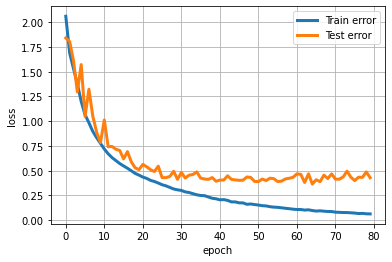

In [5]:
plt.plot(range(num_epoch),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epoch),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

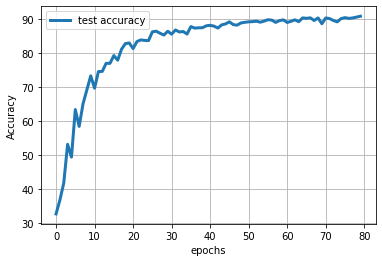

In [6]:
plt.plot(range(num_epoch), test_acc_history, '-', linewidth=3, label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

In [8]:
# save model
model_path = "./project1_model.pt"
torch.save(net.state_dict(), model_path)


In [9]:
# load model
import torch
# from project1_model import project1_model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = project1_model().to(device)
model = torch.nn.DataParallel(model)
model_path = "./project1_model.pt"
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

<All keys matched successfully>

In [10]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss/len(testloader)
    print('Testing Loss: %.4f | Acc: %.4f' % (test_loss, 100.*correct/total))

criterion = nn.CrossEntropyLoss()
test(1)

Testing Loss: 0.4283 | Acc: 90.8600
